# 3. Interpolation

```{admonition} Additional resource
:class: warning 
Shen, Z., & Serkh, K. (2022). [On polynomial interpolation in the monomial basis](https://arXiv.org/abs/2212.10519)
```

You have a function $f$ defined on the interval $[a, b]$, but only have access to $n + 1$ evaluations of the function at unique nodes $\{x_0, x_1, x_2, \ldots, x_n\} := \{x_i\}_{i=0}^n$, where the function takes values $\{ y_0, y_1, y_2, \ldots, y_n \} := \{y_i\}_{i=0}^n$. How do you evaluate the function at some new point $x^{\ast}$?

We start with the oldest trick in the book: 

## 3.1. The Vandermonde trick

Try fitting an degree-$n$ polynomial through the points,
$$ p(x) = \sum_{k = 0}^{n}a_k x^k, $$
so that the function evaluations become constraints

\begin{align}
p(x_0) &= a_0 + a_1 x_0 + a_2 x_0^2 + \ldots + a_n x_0^n = y_0,\\
p(x_1) &= a_0 + a_1 x_1 + a_2 x_1^2 + \ldots + a_n x_1^n = y_1,\\
\vdots &\vphantom{=}\\
p(x_n) &= a_0 + a_1 x_n + a_2 x_n^2 + \ldots + a_n x_n^n = y_n.
\end{align}

This can be rewritten rather compactly as

\begin{equation}
\begin{bmatrix}
1 & x_0 & x_0^2 & \ldots & x_0^n \\
1 & x_1 & x_1^2 & \ldots & x_1^n \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_n & x_n^2 & \ldots & x_n^n 
\end{bmatrix}
\begin{bmatrix}
a_0 \\ a_1 \\ \vdots \\ a_n 
\end{bmatrix}
= 
\begin{bmatrix}
y_0 \\ y_1 \\ \vdots \\ y_n 
\end{bmatrix},
\end{equation}

or simply $Ma = y$, where we collected the unknown coefficients into the vector $a$, the function evaluations into $y$, and $M(\{x^{\ast}_i\}_{i=0}^n)$ is called the **Vandermonde matrix**.

To evaluate $f$ at a new set of points $\{x^{\ast}_i\}_{i=0}^m$, we can simply solve $Ma = y$ with a backwards-stable algorithm to get $a$, and then left-multiply it by a _new_ Vandermonde matrix $N(\{x^{\ast}_i\}_{i=0}^m)$ (filled with the $\{x^{\ast}_i\}_{i=0}^m$.

```{admonition} Algorithm
:class: hint
A backwards-stable and efficient way to interpolate using the Vandermonde trick is to build an $(m+1) \times (n+1) $ interpolation matrix $L = NM^{-1}$ using the (scaled and centered) source $\{x_i\}_{i=0}^n$ and target $\{x^{\ast}_i\}_{i=0}^m$ nodes:

1. Fill up the $M$ and $N$ matrices column-by-column, using element-wise multiplication of entries with those of the previous column,
2. Compute $L$ as $L = (\text{solve}(M^{T}, N^T))^T$, or in MATLAB notation: `L = (M'\N')'`.

See, for example [this implementation](https://github.com/ahbarnett/BIE3D/blob/master/utils/interpmat_1d.m) of Helsing's algorithm by Alex Barnett.
```

```{admonition} Question
How can doing interpolation like this go wrong? (Hint: think back to the example at the end of Ch. 1.)
```

Intuitively, one might worry that if the magnitude of the (exact) coefficients $||a||$ gets large, we'll run into the same poorly conditioned problem as we did when evaluating the _expanded_ $(x-2)^9$ from the last lecture. This is a valid concern.

However, the frequently used warning of 
> avoid using Vandermonde matrices for interpolation because their condition number gets large (exponentially) quickly

is misleading, and unnecessarily restricts the use of this method. 

```{admonition} Theorem
:class: hint
The monomial/Vandermonde basis is generally as good as a well-conditioned polynomial basis for interpolation, provided that 
$$\kappa < 1/\mu_M.$$
```

To investigate when it _really_ is inappropriate to use Vandermonde matrices, we'll need to distinguish between two different sources of error: the choice of interpolating polynomial, and the choice of basis it is represented in.

## 3.2 Choice of nodes and choice of basis

```{admonition} Question
Assume that you are given the function $f$ and nothing else. What parameters are you free to pick when interpolating it?
```

If we aren't given the **interpolation/collocation nodes** $\{x_i\}_{i=0}^n$, then they are parameters of the interpolation problem. 
Once they are chosen, they determine the **interpolating polynomial/interpolant** uniquely.

But we are also free to choose the **basis** in which the interpolating polynomial is represented. In the Vandermonde case, that basis is the **monomial** one: $1, x, x^2, \ldots, x^n$. This then determines the polynomial coefficients (the $\{a_i\}_{i=0}^n$ in the Vandermonde system). Other choices include
- the Lagrange basis, $$ l_k(x) := \prod_{j = 0, j \neq k}^n \frac{x - x_j}{x_k - x_j} \quad  \text{for } k = 0, 1, \ldots n,$$
- Chebyshev polynomials,
- Legendre polynomials,
- Newton polynomials.


```{admonition} Proposition
:class: hint
The nodes $\{x_i\}_{i=0}^n$ determine the interpolant uniquely as:
$$ p(x) = \sum_{k = 0}^n y_k l_k(x), $$
since 
$$ l_k(x_i) = \begin{cases} \prod_{j \neq k} \frac{x_k - x_j}{x_k - xj} = 1 \quad &\text{if } i = k, \\
0 \quad &\text{if } i \neq k, \end{cases}
$$
so $p(x_i) = \sum y_k \delta_{ki} = y_i$ $\forall i$ is a solution and is unique.
```

### 3.2.1 Is the monomial basis a bad choice?

It is [true](https://link.springer.com/article/10.1007/PL00005392) that the condition number of the Vandermonde matrix $M$ gets exponentially large with $n$ for any set of real collocation nodes $\{x_i\}_{i=0}^n$. We can check that with a little script: 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

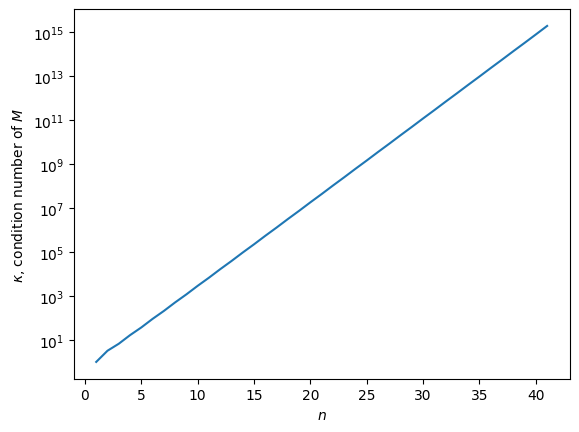

In [6]:
def vdm(x):
    """ 
    Computes the Vandermonde matrix from the input collocation nodes x.
    """
    n = x.shape[0]
    M = np.ones((n, n))
    for i in range (1, n):
        M[:, i] = M[:, i-1]*x
    return M

# Compute n+1 Chebyshev polynomial roots
chebx = lambda n: np.cos(np.linspace(0, np.pi, n+1))

n = np.arange(1, 42, dtype = int)
cond = np.array([np.linalg.cond(vdm(chebx(m))) for m in n])

plt.figure()
plt.semilogy(n, cond)
plt.xlabel("$n$")
plt.ylabel("$\\kappa$, condition number of $M$")
plt.show()

This suggests that even at the modest $n = 10$, $\kappa \approx 10^3$. But let's see if we lose accuracy already at that point:

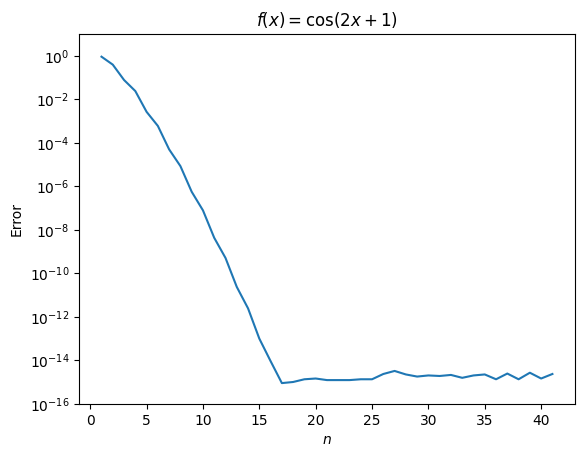

In [8]:
def interpvdm(f, x, x_star):
    """ Given a function f, collocation nodes x, and target nodes x_star,\
    computes interpolation matrix using the monomial basis and returns\
    f interpolated at x_star.
    """
    r = x.shape[0]
    q = x_star.shape[0]
    V = np.ones((r, r))
    R = np.ones((q, r))
    for j in range(1, r):
        V[:, j] = V[:, j-1]*x
        R[:, j] = R[:, j-1]*x_star
    N = np.linalg.solve(V.T, R.T).T
    f_star = np.dot(N, f(x))
    return f_star

f = lambda x: np.cos(2*x + 1)
x_star = np.linspace(-1, 1, 100)
err = np.array([np.max(np.abs(f(x_star) - interpvdm(f, chebx(m), x_star))) for m in n])

plt.figure()
plt.semilogy(n, err)
plt.title("$f(x) = \\cos(2x + 1)$");plt.xlabel("$n$");plt.ylabel("Error");plt.ylim((1e-16,10))
plt.show()

What?! Interpolation in the monomial basis seems to work just fine beyond $n = 10$, and its accuracy quickly reaches $\mu_M$. 
Now try some other functions that require higher-order interpolation either because they cross zero many times, due to a nearby singularity, or because they are non-smooth: 

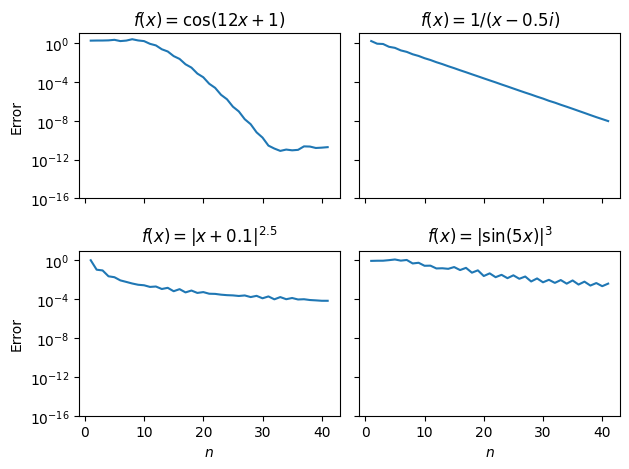

In [10]:
f = lambda x: np.cos(12*x + 1)
err1 = np.array([np.max(np.abs(f(x_star) - interpvdm(f, chebx(m), x_star))) for m in n])

f = lambda x: 1/(x - 0.5*1j)
err2 = np.array([np.max(np.abs(f(x_star) - interpvdm(f, chebx(m), x_star))) for m in n])

f = lambda x: np.abs(x + 0.1)**2.5
err3 = np.array([np.max(np.abs(f(x_star) - interpvdm(f, chebx(m), x_star))) for m in n])

f = lambda x: np.abs(np.sin(5*x))**3
err4 = np.array([np.max(np.abs(f(x_star) - interpvdm(f, chebx(m), x_star))) for m in n])

fig, ax = plt.subplots(2, 2, sharex = True, sharey = True)
plt.ylim((1e-16,1e1))
ax[0,0].semilogy(n, err1);ax[0,1].semilogy(n, err2);ax[1,0].semilogy(n, err3);ax[1,1].semilogy(n, err4)
ax[1,0].set_xlabel("$n$");ax[1,1].set_xlabel("$n$")
ax[0,0].set_ylabel("Error");ax[1,0].set_ylabel("Error")
ax[0,0].set_title("$f(x) = \\cos(12x + 1)$");ax[0,1].set_title("$f(x) = 1/(x - 0.5i)$");ax[1,0].set_title("$f(x) = |x + 0.1|^{2.5}$");ax[1,1].set_title("$f(x) = |\\sin(5x)|^3$")
plt.tight_layout();plt.show()

Here, we observe different (slower) _convergence rates_, but it's not clear whether slower convergence is due to the large condition number of $M$, or something else. Keeping the same collocation nodes, let us compare interpolation of the above functions using a different basis: the Lagrange basis. Evaluation of the interpolating polynomial $p$, unlike in the monomial basis, does not have a large $\kappa$. But first, some things to note:

```{admonition} Aside
**Convergence rates**. When we talk about "rate of convergence", we mean the rate at which error in a given algorithm decreases with computational effort (e.g. number of collocation nodes, $n$). These rates have different names that are summarized below.

|    Rate   |   Name   |
| :-------- | -------: |
| $cn^{-1}$ | first-order/algebraic |
| $cn^{-p}$ | $p$th order |
| $c_1a^{-c_2 n} = c_3e^{-c_4 n}$ | geometric/exponential |
| $c_1e^{-c_2 n^2}$ | quadratic |
| $c_1e^{-c_2 n^r}$, $r \geq 1$ | spectral |
```

```{admonition} Aside
**Optimal choice of collocation nodes**. The choice of having $\{x_i\}_{i=0}^n$ be the roots of Chebyshev polynomials is not a coincidence. These roots are projections of a half complex unit circle divided into $n$ equal arcs onto the real axis, including the endpoints $\pm 1$. It turns out that they are the _optimal_ choice for approximating smooth functions $f$, meaning that the interpolation error (assuming interpolation is done _exactly_) is minimal.
```

Interpolation in the Lagrange basis can be done in a backwards stable way via **barycentric interpolation**. We call a `scipy` routine that performs it:

In [12]:
import scipy.interpolate as sciint

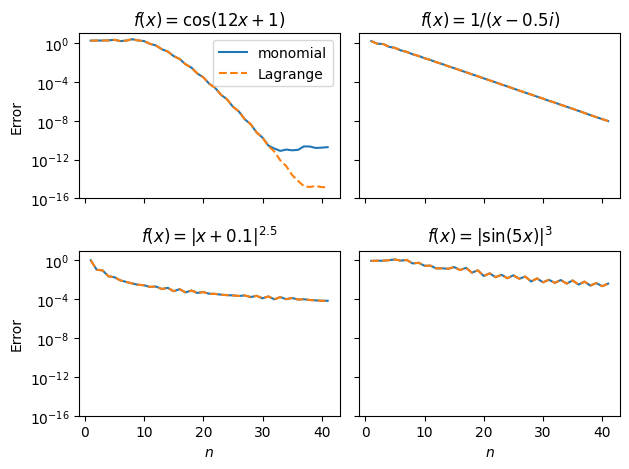

In [13]:
baryint = lambda n, f: sciint.barycentric_interpolate(chebx(n), f(chebx(n)), x_star)

f = lambda x: np.cos(12*x + 1)
err1b = np.array([np.max(np.abs(f(x_star) - baryint(m, f))) for m in n])

f = lambda x: 1/(x - 0.5*1j)
err2b = np.array([np.max(np.abs(f(x_star) - baryint(m, f))) for m in n])

f = lambda x: np.abs(x + 0.1)**2.5
err3b = np.array([np.max(np.abs(f(x_star) - baryint(m, f))) for m in n])

f = lambda x: np.abs(np.sin(5*x))**3
err4b = np.array([np.max(np.abs(f(x_star) - baryint(m, f))) for m in n])

fig, ax = plt.subplots(2, 2, sharex = True, sharey = True)
plt.ylim((1e-16,1e1))
ax[0,0].semilogy(n, err1, label = "monomial");ax[0,1].semilogy(n, err2);ax[1,0].semilogy(n, err3);ax[1,1].semilogy(n, err4)
ax[0,0].semilogy(n, err1b, '--', label = "Lagrange");ax[0,1].semilogy(n, err2b, '--');ax[1,0].semilogy(n, err3b, '--');ax[1,1].semilogy(n, err4b, '--')
ax[1,0].set_xlabel("$n$");ax[1,1].set_xlabel("$n$");ax[0,0].set_ylabel("Error");ax[1,0].set_ylabel("Error")
ax[0,0].set_title("$f(x) = \\cos(12x + 1)$");ax[0,1].set_title("$f(x) = 1/(x - 0.5i)$");ax[1,0].set_title("$f(x) = |x + 0.1|^{2.5}$");ax[1,1].set_title("$f(x) = |\\sin(5x)|^3$")
ax[0,0].legend()
plt.tight_layout();plt.show()

```{admonition} Question
What do we observe here and what does it tell us about the source of error in interpolation in the monomial basis?
```

It seems from above that interpolation in the monomial basis is pretty much as accurate as expressing the interpolant in the Lagrange basis (via the barycentric formula). But we know that the latter is a well-conditioned problem, so clearly the slower convergence in some of the plots cannot be a consequence of the large $\kappa$ of $M$. But, there is a clue: convergence of interpolation in the monomial basis stagnates at $10^{-12}$ for the top left $f(x) = \cos(12x + 1)$, whereas barycentric interpolation gets the error down to $\mu_M$. Where does this stagnation come from?

```{admonition} Question
What does $\kappa_M$ measure?
```

The condition number $\kappa$ of $M$ measures the _forward_ error, 
$$ \frac{||a - \tilde{a}||}{||a||}, $$
where $\tilde{a}$ is the computed and $a$ is the exact coefficient vector. This can be huge, because of the large $\kappa$. However, the (absolute) _backward error_
$$ ||M\tilde{a} - f|| $$
is small thanks to backwards stability of the interpolation formula, and this is what matters for the interpolation accuracy.

```{admonition} Question
What does a small backward error imply for $\tilde{p} - p$?
```

If the computed polynomial expansion is $\tilde{p}$, then a small backward error implies that $\tilde{p} - p$, is almost $0$ at the $\{x_i\}_{i=0}^n$ (we found a poly that has nearly the same roots). If the interpolating polynomial was chosen appropriately (via the choice of nodes $\{x_i\}_{i=0}^n$), then 
$$ ||p - \tilde{p}||_{L_{\infty}([-1, 1])} \leq c|| M\tilde{a} - f ||, $$
i.e. the error in approximating the exact polynomial $p$ is bounded by the backward error times a small constant $c$.


This can be used to bound the error of monomial interpolation,
$$ ||f - \tilde{p}||_{L_{\infty}([-1, 1])} \leq ||f - p||_{L_{\infty}([-1, 1])} + || p - \tilde{p} ||_{L_{\infty}([-1, 1])},$$
where the first term on the RHS is the _polynomial interpolation error_ (coming entirely from the choice of nodes), and the second is (proportional to) the backward error (and is due to our choice of representation). 

It turns out that as long as the backward error is smaller than the polynomial interpolation error, the use of the monomial basis doesn't incur significant additional error. But once the first term becomes smaller than the backward error, accuracy stagnates.

```{admonition} Question
But when is the backward error small?
```

Backwards stability guarantees that $\tilde{a}$ solves an approximate problem
$$ (M + \delta M)\tilde{a} = f, $$
(check this yourself!), with $||\delta M||/||M|| = \mathcal{O}(\mu_M)$. Then, rearranging, we get
$$ || M\tilde{a} - f|| \leq ||\delta M || ||\tilde{a}|| = ||M|| ||\tilde{a}|| \mathcal{O}(\mu_M),$$
where $||M||$ is typically small. Therefore it is the $||\tilde{a}||$, the magnitude of the computed coefficients, that determines the backward error. In a backwards stable solver, it can be shown that
$$ ||\tilde{a}|| \approx ||a|| \quad \text{as long as }\kappa \leq \frac{1}{\mu_M} \approx 10^{16}.$$
Therefore,

```{admonition} Result
:class: hint 
- We need not worry about the poor conditioning of the Vandermonde matrix until its condition number becomes $1/\mu_M$ (in practice, at around $n \approx 40$), and 
- $||\tilde{a}||$ is a good predictor of the error induced by the use of the monomial basis. When this gets large, that's when we _do_ need to worry about our choice of basis!
```

Let's revisit the interpolation examples one more time, this time trying to explain the (lack of) stagnation in the accuracy by checking the backward error $||\tilde{a}||\mu_M$:

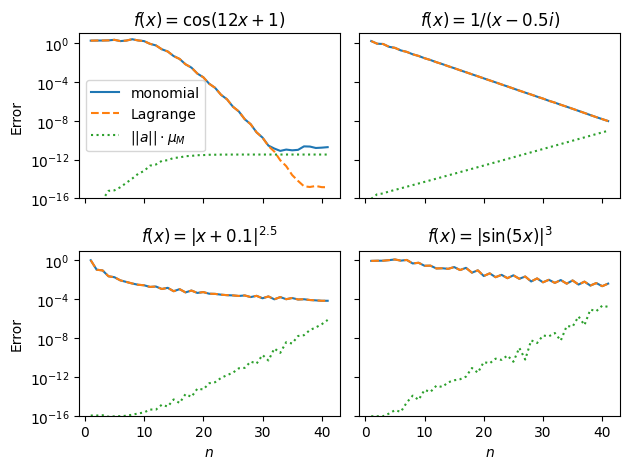

In [14]:
def vdmcoeffs(x, f):
    """ Given a function f and collocation nodes x, computes\
    the 2-norm of the polynomial coefficient vector in the monomial\
    basis.
    """
    r = x.shape[0]
    V = np.ones((r, r))
    for j in range(1, r):
        V[:, j] = V[:, j-1]*x
    a = np.linalg.solve(V, f(x))
    return np.linalg.norm(a)


f = lambda x: np.cos(12*x + 1)
err1p = 1e-16*np.array([vdmcoeffs(chebx(m), f) for m in n])

f = lambda x: 1/(x - 0.5*1j)
err2p = 1e-16*np.array([vdmcoeffs(chebx(m), f) for m in n])

f = lambda x: np.abs(x + 0.1)**2.5
err3p = 1e-16*np.array([vdmcoeffs(chebx(m), f) for m in n])

f = lambda x: np.abs(np.sin(5*x))**3
err4p = 1e-16*np.array([vdmcoeffs(chebx(m), f) for m in n])

fig, ax = plt.subplots(2, 2, sharex = True, sharey = True)
plt.ylim((1e-16,1e1))
ax[0,0].semilogy(n, err1, label = "monomial");ax[0,1].semilogy(n, err2);ax[1,0].semilogy(n, err3);ax[1,1].semilogy(n, err4)
ax[0,0].semilogy(n, err1b, '--', label = "Lagrange");ax[0,1].semilogy(n, err2b, '--');ax[1,0].semilogy(n, err3b, '--');ax[1,1].semilogy(n, err4b, '--')
ax[0,0].semilogy(n, err1p, ':', label = "$||a||\\cdot \\mu_M$");ax[0,1].semilogy(n, err2p, ':');ax[1,0].semilogy(n, err3p, ':');ax[1,1].semilogy(n, err4p, ':')

ax[1,0].set_xlabel("$n$");ax[1,1].set_xlabel("$n$");ax[0,0].set_ylabel("Error");ax[1,0].set_ylabel("Error")
ax[0,0].set_title("$f(x) = \\cos(12x + 1)$");ax[0,1].set_title("$f(x) = 1/(x - 0.5i)$");ax[1,0].set_title("$f(x) = |x + 0.1|^{2.5}$");ax[1,1].set_title("$f(x) = |\\sin(5x)|^3$")
ax[0,0].legend()
plt.tight_layout();plt.show()

## 3.3 Barycentric interpolation

For when the monomial basis produces a large backward error, an alternative representation of the interpolating polynomial $p$ is in the Lagrange basis, with basis functions
$$l_j(x) = \frac{\prod_{k \neq j} (x - x_k)}{\prod_{k \neq j} (x_j - x_k)} \quad \text{for } j = 0, 1, 2, \ldots, n.$$
The polynomial is then
$$ p(x) = \sum_{j = 0}^n y_j l_j(x), $$
where, recall, $y_j = f(x_j)$. 

Naively evaluating $p$ at each $x$ using this formula takes $\mathcal{O}(n^2)$ effort, 

```{admonition} Question
Why?
```

because each $l_j$ takes $\mathcal{O}(n)$ operations (a product of $n$ terms), then it takes $\mathcal{O}(n)$ again to add them up. For a large number of $x$, this is unacceptably slow, and we can actually do it in $\mathcal{O}(n)$ time.

```{admonition} Aside
:class: hint
**The 3 important plots.**
 We already talked about the _convergence rate_ of an algorithm (and the most important plot: the error vs computational effort), and now a new concept is its **complexity**. This is another important plot that shows the scaling of computational _cost_ (i.e. time) with effort, e.g. $n$. The third plot is not independent of these two, the **work-precision** diagram shows the error as a function of computational cost, which is important for practical considerations.
To summarize:
- convergence: error $\delta$ vs. effort $n$,
- complexity: cost $t$ vs effort $n$,
- work-precision: error $\delta$ vs. cost $t$.

```


The idea behing the $\mathcal{O}(n)$ algorithm is to observe that the numerator of the $l_j$-s have common factors. Define the **node polynomial**
$$ l(x) := \prod_{k = 0}^n (x - x_k) $$
containing all of those factors. Then
$$ l_j(x) = \frac{l(x)}{l'(x_j)(x - x_j)}. $$
```{admonition} Question
Show this yourself using l'H\^{o}pital's rule.
```
Also define the **weights**
$$ \lambda_j = \frac{1}{\prod_{k \neq j}(x_j - x_k)}, $$
which are none other than $\lambda_j = \frac{1}{l'(x_j)}$.
```{admonition} Question
Verify this yourself.
```
Substituting into our expression for $l_j(x)$, we get
$$ l_j(x) = l(x)\frac{\lambda_j}{x - x_j}, $$
and into $p(x)$ to get
$$ p(x) = l(x) \sum_{j = 0}^n \frac{\lambda_j}{x - x_j}y_j. $$

The weights $\lambda_j$ takes $\mathcal{O}(n^2)$ time, but the big difference is that they only need to be computed _once_, and not for each $x$. In the best case, for e.g. Chebyshev collocation nodes, they are known analytically.
Once the weights are known, evaluating $p(x)$ then only takes $\mathcal{O}(n)$ effort.

```{admonition} Exercise
:class: danger
- a) Write code using the barycentric interpolation formula (you may use an external package for this, or you may write your own) to compute a sequence of polynomial interpolants to a function $f$ on $[−1, 1]$ in points selected by a _greedy_ algorithm: take $x_0$ to be a point where $|f(x)|$ achieves its maximum, then $x_1$ to be a point where $|(f − p_0)(x)|$ achieves its maximum, then $x_2$ to be a point where $|(f − p_1)(x)|$ achieves its maximum, and so on. Plot the error curves $(f − p_n)(x)$, $x \in [−1, 1]$, computed by this algorithm for $f(x) = |x|$ and $0 \leq n \leq 25$. Comment on the spacing of the grid $\{ x_0, x_1, \ldots, x_{25} \}$.
- b) Make sure to write a _unit test_ for your interpolation routine, and put "test" in the function's name.
- c) Write _docstrings_ for your functions documenting the types and any limitations on their input, their outputs, and what they do. 
```